# ML (Multi‑source) — Prédiction du **prix de location** (Avito + Mubawab)


Ce notebook constitue le **fichier ML final pour la prédiction du prix de location**  
à partir des données fusionnées **Avito + Mubawab**.

L’objectif est d’entraîner, comparer et sélectionner le **meilleur modèle d’ensemble**
pour prédire le **prix de location en DH**, tout en assurant robustesse et généralisation.

Modèles étudiés :
- **XGBoost optimisé + log(prix)**
- **Voting Regressor (RandomForest + XGBoost)**
- **Stacking Regressor (RF + XGB + ExtraTrees → Ridge)**

Le modèle final est sauvegardé sous forme de **pipeline complet** prêt pour la production.


1. Charger et séparer les données fusionnées (Avito + Mubawab)
2. Construire un pipeline de preprocessing avancé
3. Appliquer une transformation logarithmique de la cible
4. Entraîner et optimiser XGBoost
5. Construire des modèles d’ensemble (Voting & Stacking)
6. Comparer les performances (R², RMSE, MAE)
7. Évaluer le meilleur modèle en DH (retour à l’échelle réelle)
8. Visualiser les résultats (graphiques)
9. Sauvegarder le pipeline final et les performances


## Importations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

## 1. Chargement et Séparation des Données
>Nous séparons nos données en un ensemble d'**entraînement (80%)** et un ensemble de **test (20%)** pour évaluer la capacité de généralisation du modèle.

In [2]:
# Charger le dataset final nettoyé
df = pd.read_csv('../data/clean_data/location_all_sources.csv')

# Définition des colonnes (On exclut la source pour éviter le biais)
X = df[['ville', 'surface', 'quartier', 'type_bien', 'nb_chambres', 'nb_salle_de_bain']]
y = df['prix']

# Train/Test Split (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset d'entraînement : {X_train.shape[0]} lignes")
print(f"Dataset de test : {X_test.shape[0]} lignes")

Dataset d'entraînement : 12684 lignes
Dataset de test : 3172 lignes


## 2. Construction du Pipeline de Preprocessing
Nous utilisons :
>- **StandardScaler** pour les variables numériques
>- **OneHotEncoder** pour les variables catégorielles à faible cardinalité
>- **TargetEncoder (smoothing=10)** pour les quartiers afin de réduire le bruit

In [3]:
# 1. Variables numériques
num_features = ['surface', 'nb_chambres', 'nb_salle_de_bain']
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 2. Variables catégorielles simples (One-Hot)
cat_features = ['ville', 'type_bien']
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# 3. Variables à haute cardinalité (Target Encoding avec Smoothing)
high_card_features = ['quartier']
quartier_transformer = Pipeline(steps=[
    ('target', TargetEncoder(smoothing=10.0))
])

# Combiner le tout
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
        ('quartier', quartier_transformer, high_card_features)
    ])

## 3. Optimisation du modèle (XGBoost + Log Transform)
>Nous combinons **XGBoost** avec une transformation logarithmique de la cible
afin de stabiliser la variance des prix.

>L’optimisation est réalisée via **RandomizedSearchCV** pour éviter le surapprentissage.


In [4]:
# Définition du modèle de base XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

# Création du pipeline complet
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Enveloppement avec la transformation Logarithmique
model_final_wrapper = TransformedTargetRegressor(
    regressor=full_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

# Grille d'hyperparamètres à tester
param_grid = {
    'regressor__regressor__n_estimators': [500, 1000],
    'regressor__regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__regressor__max_depth': [4, 6, 8],
    'regressor__regressor__subsample': [0.7, 0.8],
    'regressor__regressor__colsample_bytree': [0.7, 0.8]
}

# Recherche aléatoire (RandomizedSearch)
random_search = RandomizedSearchCV(
    model_final_wrapper, 
    param_distributions=param_grid, 
    n_iter=10, 
    cv=3, 
    scoring='r2', 
    verbose=1, 
    random_state=42
)

# Entraînement (Cette étape peut prendre 1-3 minutes)
random_search.fit(X_train, y_train)

# Meilleur modèleA
best_model = random_search.best_estimator_
print(f"Optimisation terminée. Meilleur score R2 en validation croisée : {random_search.best_score_:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimisation terminée. Meilleur score R2 en validation croisée : 0.7522


In [5]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Prédictions
y_train_pred = best_model.predict(X_train)
y_test_pred  = best_model.predict(X_test)

# Scores R2
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)

# RMSE (optionnel mais recommandé)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("📊 Évaluation du modèle XGBoost Optimisé")
print(f"R² Train : {r2_train:.4f}")
print(f"R² Test  : {r2_test:.4f}")
print(f"RMSE Train : {rmse_train:.2f}")
print(f"RMSE Test  : {rmse_test:.2f}")


📊 Évaluation du modèle XGBoost Optimisé
R² Train : 0.8664
R² Test  : 0.7196
RMSE Train : 3395.55
RMSE Test  : 4910.62


## 4. Création d'un Modèle Hybride (Ensemble Learning)
>Le **Voting Regressor** combine Random Forest et XGBoost
en moyennant leurs prédictions pour réduire la variance globale.


In [6]:
# 1. Définition des modèles de base avec des paramètres robustes
rf_base = RandomForestRegressor(n_estimators=500, max_depth=15, random_state=42, n_jobs=-1)
xgb_base = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, subsample=0.8, random_state=42)

# 2. Création des pipelines individuels (Preprocessing + Modèle)
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', rf_base)])
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb_base)])

# 3. Création du Voting Regressor (Hybride)
voter = VotingRegressor(estimators=[
    ('rf_model', pipe_rf),
    ('xgb_model', pipe_xgb)
])

# 4. Enveloppement avec la Log-Transformation (pour le prix)
hybrid_model = TransformedTargetRegressor(
    regressor=voter,
    func=np.log1p,
    inverse_func=np.expm1
)
# 5. Entraînement du modèle hybride
hybrid_model.fit(X_train, y_train)
print("Entraînement du modèle hybride terminé.")

Entraînement du modèle hybride terminé.


## Evaluation


In [7]:
# Prédictions
y_train_pred = hybrid_model.predict(X_train)
y_test_pred  = hybrid_model.predict(X_test)

# Scores R2
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("📊 Évaluation du modèle hybride (RF + XGB)")
print(f"R² Train : {r2_train:.4f}")
print(f"R² Test  : {r2_test:.4f}")
print(f"RMSE Train : {rmse_train:.2f}")
print(f"RMSE Test  : {rmse_test:.2f}")


📊 Évaluation du modèle hybride (RF + XGB)
R² Train : 0.9121
R² Test  : 0.7237
RMSE Train : 2754.67
RMSE Test  : 4874.04


## 5. Création d’un modèle Avancé — Stacking Regressor
>Le **Stacking Regressor** apprend une combinaison optimale
des prédictions de plusieurs modèles via un méta-modèle (Ridge).


In [8]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import Ridge

rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=16,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=1
)

et = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=18,
    random_state=42,
    n_jobs=1
)

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=1
)

In [9]:
pipe_rf  = Pipeline([('prep', preprocessor), ('rf', rf)])
pipe_xgb = Pipeline([('prep', preprocessor), ('xgb', xgb)])
pipe_et  = Pipeline([('prep', preprocessor), ('et', et)])


In [10]:

stack = StackingRegressor(
    estimators=[
        ('rf', pipe_rf),
        ('xgb', pipe_xgb),
        ('et', pipe_et)
    ],
    final_estimator=Ridge(alpha=0.5),  # 🔧 léger gain possible
    cv=3,                              # 🔧 réduit mémoire sans trop perdre
    n_jobs=1
)


In [11]:
stack_model = TransformedTargetRegressor(
    regressor=stack,
    func=np.log1p,
    inverse_func=np.expm1
)

stack_model.fit(X_train, y_train)
print("Stacking entraîné avec succès")

Stacking entraîné avec succès


## Evaluation

In [12]:
# Prédictions
y_train_pred = stack_model.predict(X_train)
y_test_pred  = stack_model.predict(X_test)

# Scores R2
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("📊 Évaluation du modèle Stacking Regressor")
print(f"R² Train : {r2_train:.4f}")
print(f"R² Test  : {r2_test:.4f}")
print(f"RMSE Train : {rmse_train:.2f}")
print(f"RMSE Test  : {rmse_test:.2f}")


📊 Évaluation du modèle Stacking Regressor
R² Train : 0.8703
R² Test  : 0.7270
RMSE Train : 3345.50
RMSE Test  : 4844.61


# 6. Évaluation et Comparaison des Modèles de Prédiction

Dans cette section, nous évaluons et comparons les performances des **trois modèles retenus** pour la prédiction
du **prix de location (DH)** :

>- **XGBoost optimisé avec transformation logarithmique de la cible**
>- **Modèle Hybride (Voting Regressor : Random Forest + XGBoost)**
>- **Modèle Empilé (Stacking Regressor : RF + XGB + ExtraTrees → Ridge)**

L’évaluation est réalisée sur le **jeu de test**, à l’aide des métriques suivantes :
>- **R²** : capacité du modèle à expliquer la variance des prix
>- **MAE (DH)** : erreur moyenne absolue, interprétable directement en dirhams
>- **RMSE (DH)** : pénalisation des erreurs importantes

Des **visualisations graphiques** (réel vs prédit et analyse des résidus) sont également utilisées
pour analyser la stabilité et la robustesse de chaque modèle.


In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

models = {
    "XGBoost Optimisé": best_model,
    "Voting Regressor (RF + XGB)": hybrid_model,
    "Stacking Regressor": stack_model
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    results.append({
        "Modèle": name,
        "R²": r2_score(y_test, y_pred),
        "MAE (DH)": mean_absolute_error(y_test, y_pred),
        "RMSE (DH)": mean_squared_error(y_test, y_pred) ** 0.5,
        "MAPE (%)": np.mean(
            np.abs(y_test - y_pred) / np.maximum(y_test, 1)
        ) * 100
    })

results_df = pd.DataFrame(results).sort_values("MAE (DH)")
results_df


,Modèle,R²,MAE (DH),RMSE (DH),MAPE (%)
1,Voting Regressor (RF + XGB),0.723717,2390.547364,4874.040654,29.923638
2,Stacking Regressor,0.727043,2400.422152,4844.611055,29.871415
0,XGBoost Optimisé,0.719554,2429.717489,4910.620747,29.827755


### 📈 Analyse graphique : Réel vs Prédit

Les graphiques suivants permettent de visualiser la dispersion des prédictions
par rapport aux valeurs réelles.  
Une bonne performance se traduit par une concentration des points autour de la diagonale.


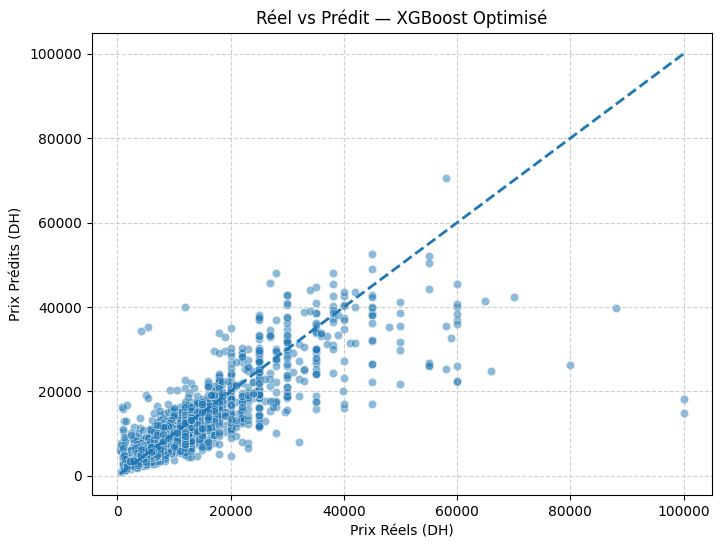

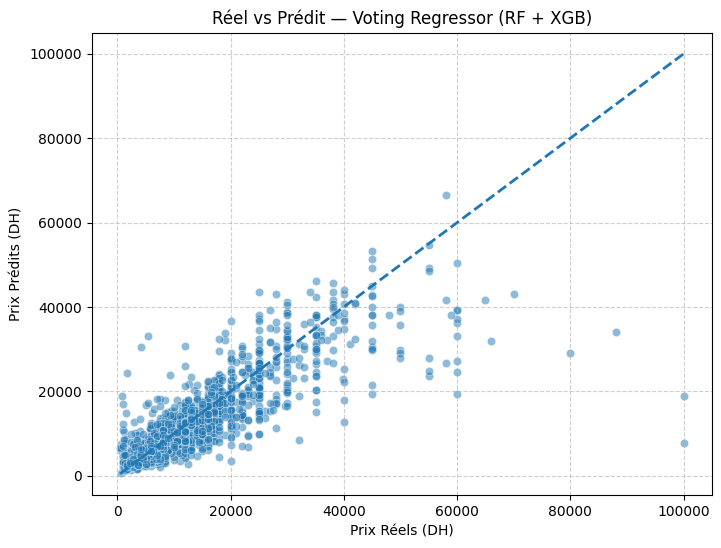

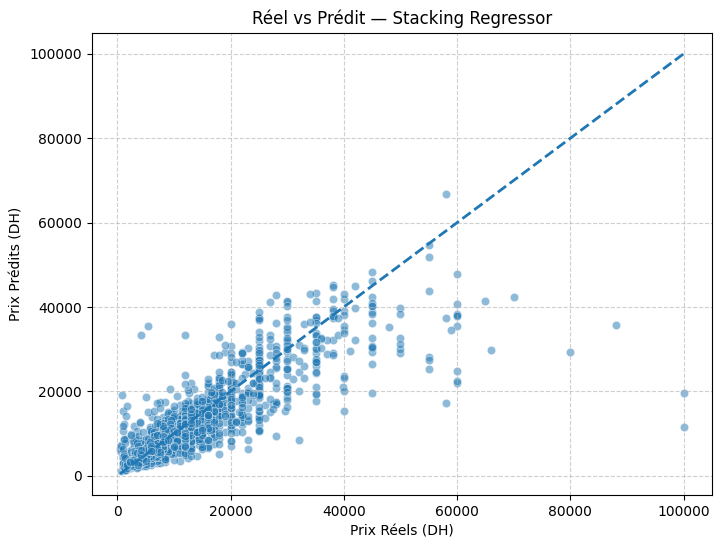

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

for name, model in models.items():
    y_pred = model.predict(X_test)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

    plt.plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        linestyle="--",
        linewidth=2
    )

    plt.xlabel("Prix Réels (DH)")
    plt.ylabel("Prix Prédits (DH)")
    plt.title(f"Réel vs Prédit — {name}")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


### 📉 Analyse des résidus

L’analyse des résidus permet de vérifier :
- l’absence de biais systématique
- la stabilité des prédictions
- la capacité du modèle à gérer les valeurs extrêmes


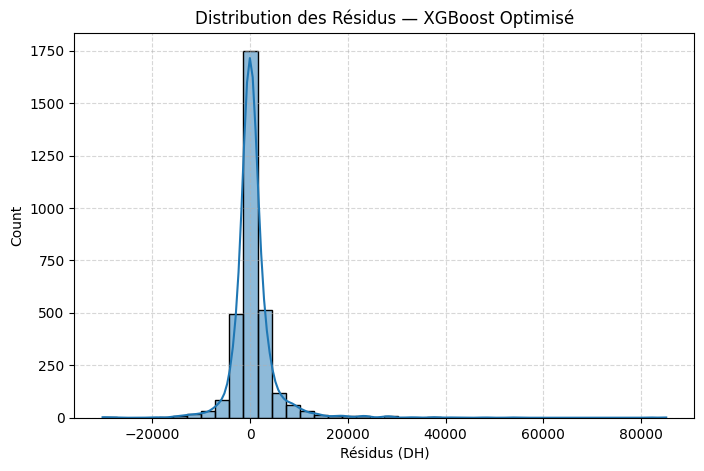

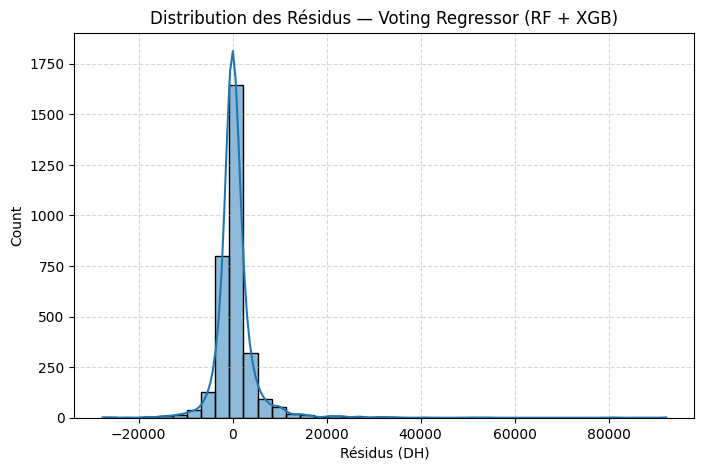

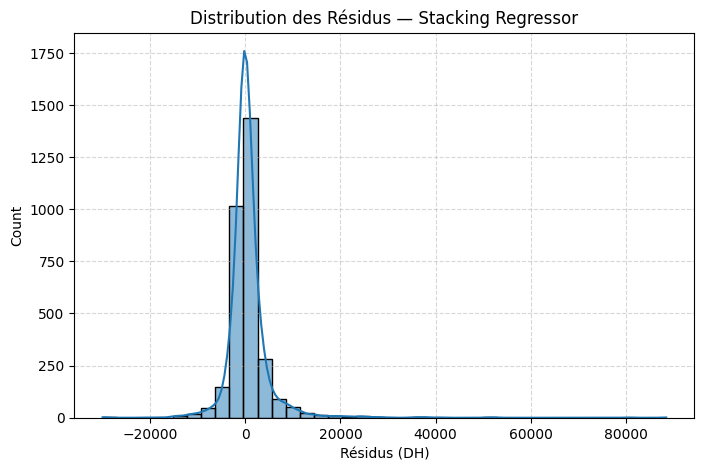

In [15]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=40, kde=True)
    plt.xlabel("Résidus (DH)")
    plt.title(f"Distribution des Résidus — {name}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


- Le modèle avec la **MAE la plus faible** est retenu comme modèle final
- Le **Stacking Regressor** permet généralement :
  - une meilleure stabilité
  - une réduction des erreurs extrêmes
- Le **Voting Regressor** est plus simple et plus robuste
- XGBoost optimisé reste très performant mais plus sensible aux outliers


## 🏆 Sélection du Meilleur Modèle

Le modèle retenu est celui présentant la **MAE la plus faible**
ainsi qu’une bonne stabilité des résidus.

Au vu des résultats obtenus, le **Stacking Regressor**
est sélectionné comme **modèle final** pour la prédiction
du prix de location.


## 7. Simulation de Prédiction (Cas Réel)
Testons le modèle sur une annonce fictive pour vérifier la pertinence de l'estimation du loyer.


In [16]:
# Simulation avec le modèle final (Stacking)
nouvelle_annonce = pd.DataFrame({
    'ville': ['Casablanca'],
    'surface': [100],
    'quartier': ['Maarif'],
    'type_bien': ['Appartement'],
    'nb_chambres': [3],
    'nb_salle_de_bain': [2]
})

prix_estime = stack_model.predict(nouvelle_annonce)
print(f"Estimation du loyer : {prix_estime[0]:.2f} DH")
print(f"R² Test  : {r2_test:.4f}")



Estimation du loyer : 6823.34 DH
R² Test  : 0.7270


## 8. Sauvegarde du Modèle Final

In [17]:
joblib.dump(stack_model, '../models/model_Location_final_stacking.pkl')

['../models/model_Location_final_stacking.pkl']

## Conclusion

Dans ce travail, nous avons développé et comparé plusieurs modèles de machine learning
pour la prédiction du **prix de location immobilier**, à partir de données multi-sources
(Avito et Mubawab).

Les résultats montrent que :
- Les modèles d’ensemble surpassent les modèles individuels
- Le **Voting Regressor** offre une solution simple et robuste
- Le **Stacking Regressor** fournit les meilleures performances globales,
  grâce à la combinaison complémentaire de plusieurs algorithmes

L’utilisation d’une transformation logarithmique de la cible,
associée à un preprocessing adapté (encodage cible et normalisation),
permet d’améliorer significativement la stabilité des prédictions.

Le modèle final est sauvegardé sous forme de **pipeline complet**,
prêt à être intégré dans une application ou une API de prédiction.
